In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/FoggyDatasetProject"
print("📁 Files in dataset folder:", os.listdir(dataset_path))

📁 Files in dataset folder: ['README.dataset.txt', 'README.roboflow.txt', 'valid', 'train', 'test', 'RTTS', 'data.yaml']


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.3 MB/s eta 0:00:00


In [ ]:
# 🏋️ TRAIN YOLOv8 MODEL
# ==============================================
from ultralytics import YOLO

# Load pretrained YOLOv8 model
model = YOLO("yolov8n.pt")

# Train the model
results = model.train(
    data="/content/drive/MyDrive/FoggyDatasetProject/data.yaml",
    epochs=50,
    imgsz=1000,
    batch=8
)

# Evaluate the model
metrics = model.val()

# Print available metric keys
print("✅ Available metric keys:", metrics.results_dict.keys())

# Extract metrics safely
mp = metrics.box.mp if hasattr(metrics.box, "mp") else metrics.box.p.mean()
mr = metrics.box.mr if hasattr(metrics.box, "mr") else metrics.box.r.mean()
map50 = metrics.box.map50 if hasattr(metrics.box, "map50") else metrics.box.ap50.mean()
map50_95 = metrics.box.map if hasattr(metrics.box, "map") else metrics.box.ap.mean()

print("\n📊 Model Performance Metrics:")
print(f"Precision (mP): {mp:.4f}")
print(f"Recall (mR): {mr:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.5:0.95: {map50_95:.4f}")

accuracy = (mp + mr) / 2
print(f"Estimated Accuracy: {accuracy:.4f}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/FoggyDatasetProject/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1000, int8

In [ ]:
!find /content/drive/MyDrive/FoggyDatasetProject -type f -name "best.pt"

!ls /content/runs/
!ls /content/drive/MyDrive/FoggyDatasetProject
print(os.listdir("/content/drive/MyDrive/FoggyDatasetProject"))

detect
data.yaml  README.dataset.txt  README.roboflow.txt  RTTS  test	train  valid
['README.dataset.txt', 'README.roboflow.txt', 'valid', 'train', 'test', 'RTTS', 'data.yaml']


In [ ]:
!find /content -type d -name "weights"
!ls /content/runs/detect/train/weights
!ls /content/runs/detect/train2/weights

/content/runs/detect/train/weights
best.pt  last.pt
ls: cannot access '/content/runs/detect/train2/weights': No such file or directory


Saving foggy.jpg to foggy.jpg

🔍 Detecting objects in: foggy.jpg

image 1/1 /content/foggy.jpg: 608x1024 2 objects, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 1024)
Results saved to /content/runs/detect/predict
✅ Detection completed: /content/runs/detect/predict/foggy.jpg


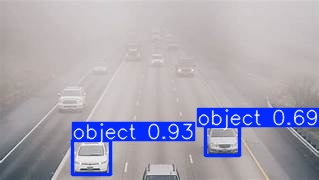

In [ ]:
from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
import pathlib

uploaded = files.upload()

model = YOLO("/content/runs/detect/train/weights/best.pt")  # or train2 if needed

for filename in uploaded.keys():
    print(f"\n🔍 Detecting objects in: {filename}")
    results = model.predict(source=filename, conf=0.25, save=True)

    output_path = pathlib.Path(results[0].save_dir) / filename
    print(f"✅ Detection completed: {output_path}")
    display(Image(filename=str(output_path)))

📸 Click the '📸 Capture Frame' button below to take a picture:
✅ Frame captured!

0: 480x640 1 person, 41.9ms
Speed: 1.3ms preprocess, 41.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


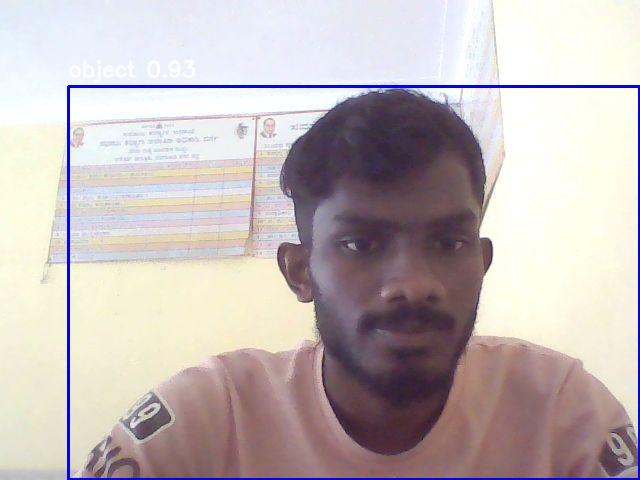

In [ ]:
# 🖥️ WEBCAM CAPTURE AND DETECTION
from ultralytics import YOLO
import cv2
from google.colab import output
import numpy as np
from base64 import b64decode, b64encode
from PIL import Image as PILImage
from io import BytesIO
from IPython.display import HTML, display, Image

def take_photo(filename='photo.jpg', quality=0.8):
    js = """
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture Frame';
      div.appendChild(capture);
      document.body.appendChild(div);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      video.remove();
      div.remove();

      const dataUrl = canvas.toDataURL('image/jpeg', quality);
      return dataUrl;
    }
    takePhoto(%f);
    """ % quality

    data = output.eval_js(js)
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

model = YOLO("yolov8n.pt")

print("📸 Click the '📸 Capture Frame' button below to take a picture:")
photo_path = take_photo("frame.jpg")
print("✅ Frame captured!")

frame = cv2.imread(photo_path)
results = model(frame, stream=True)

for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f"object {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

cv2.imwrite("detected.jpg", frame)
display(Image("detected.jpg"))

📤 Please select one or more image files to upload...


Saving bicycle.jpg to bicycle.jpg
Saving bikes.jpg to bikes.jpg

🔍 Detecting objects in: bicycle.jpg

image 1/1 /content/bicycle.jpg: 480x640 2 persons, 2 bicycles, 2 cars, 1 motorcycle, 72.2ms
Speed: 5.7ms preprocess, 72.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict2

🧠 Detected Objects:
➡️ person: 0.89
➡️ person: 0.82
➡️ car: 0.67
➡️ bicycle: 0.66
➡️ car: 0.37
➡️ bicycle: 0.36
➡️ motorcycle: 0.27

✅ Detection completed: /content/runs/detect/predict2/bicycle.jpg


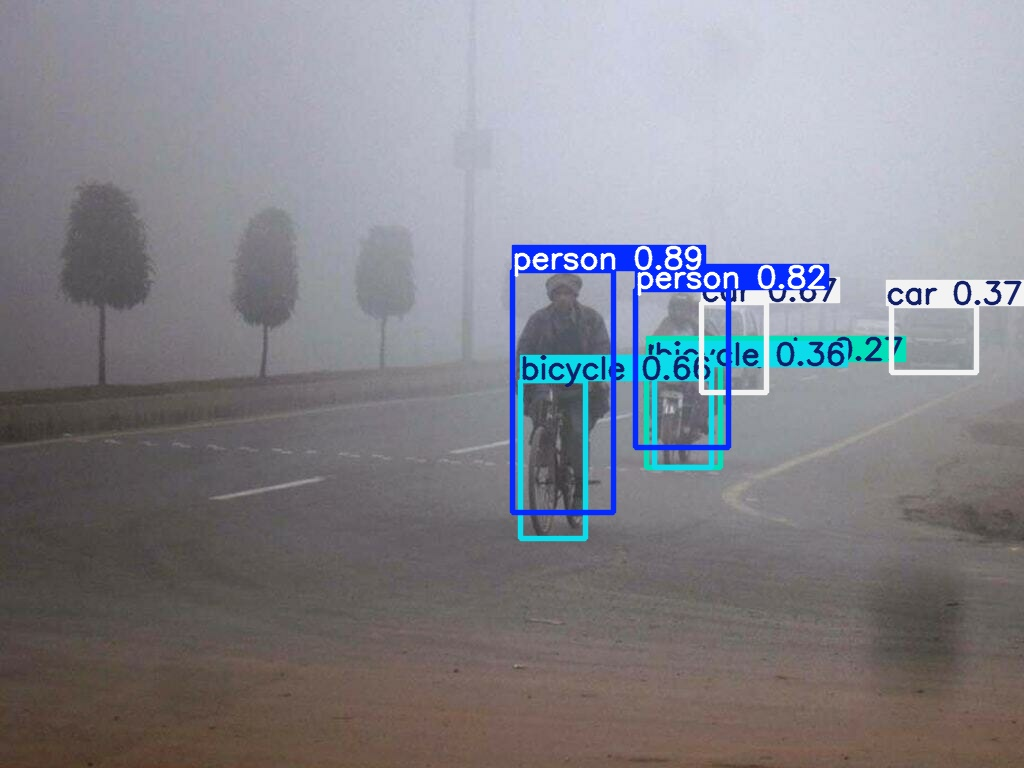


🔍 Detecting objects in: bikes.jpg

image 1/1 /content/bikes.jpg: 384x640 4 persons, 1 car, 2 motorcycles, 65.9ms
Speed: 2.9ms preprocess, 65.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict2

🧠 Detected Objects:
➡️ person: 0.87
➡️ car: 0.85
➡️ motorcycle: 0.60
➡️ person: 0.56
➡️ motorcycle: 0.55
➡️ person: 0.50
➡️ person: 0.48

✅ Detection completed: /content/runs/detect/predict2/bikes.jpg


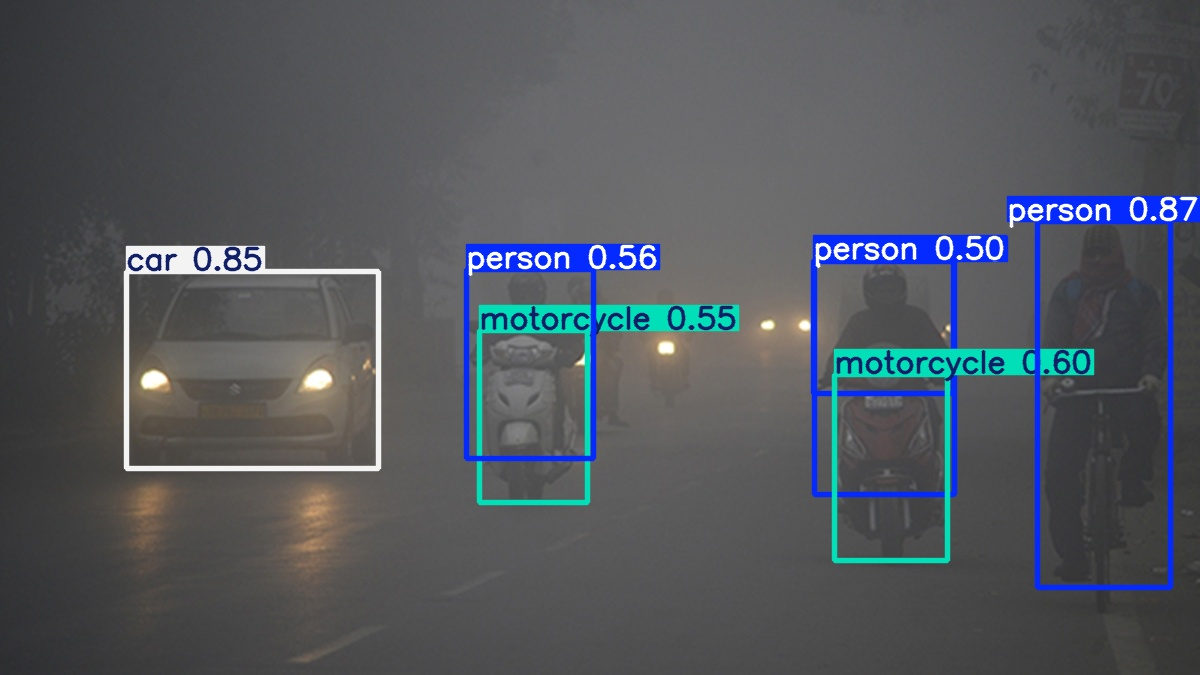


🎉 All detections completed!


In [ ]:
# 📤 MULTIPLE IMAGE DETECTION
# ==============================================
from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
import pathlib

print("📤 Please select one or more image files to upload...")
uploaded = files.upload()

model = YOLO("yolov8n.pt")  # ✅ pretrained COCO model

for filename in uploaded.keys():
    print(f"\n🔍 Detecting objects in: {filename}")
    results = model.predict(source=filename, conf=0.25, save=True)

    for result in results:
        boxes = result.boxes
        names = model.names

        print("\n🧠 Detected Objects:")
        if len(boxes) == 0:
            print("⚠️ No objects detected.")
        else:
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                label = names[cls_id]
                print(f"➡️ {label}: {conf:.2f}")

    output_path = pathlib.Path(results[0].save_dir) / filename
    print(f"\n✅ Detection completed: {output_path}")
    display(Image(filename=str(output_path)))

print("\n🎉 All detections completed!")

In [ ]:
%%writefile app.py
import streamlit as st
import cv2
from ultralytics import YOLO
import numpy as np
import time

# ------------------------
# Page Configuration
# ------------------------
st.set_page_config(page_title="YOLOv8 Real-Time Detection", layout="wide")

# ------------------------
# Custom CSS for black theme and centered content
# ------------------------
st.markdown("""
<style>
body {
    background-color: #111111;
    color: white;
}

h1 {
    text-align: center;
    color: white;
    font-size: 48px;
    animation: pulse 2s infinite;
}

@keyframes pulse {
    0% { text-shadow: 0 0 5px #fff; }
    50% { text-shadow: 0 0 20px #4CAF50, 0 0 30px #4CAF50; }
    100% { text-shadow: 0 0 5px #fff; }
}

.css-18e3th9 {  /* Main content block */
    display: flex;
    justify-content: center;
    align-items: center;
    flex-direction: column;
}
.stButton button {
    background-color: #4CAF50;
    color: white;
}
</style>
""", unsafe_allow_html=True)

# ------------------------
# Title
# ------------------------
st.markdown("<h1>🎥 YOLOv8 Real-Time Detection</h1>", unsafe_allow_html=True)

st.write("Click the checkbox to start the webcam (works only on your local system).")

# ------------------------
# Load YOLO model
# ------------------------
model = YOLO("yolov8n.pt")  # Ensure yolov8n.pt is in the same folder

# ------------------------
# Start Webcam
# ------------------------
run = st.checkbox("Start Camera")
FRAME_WINDOW = st.image([])

if run:
    camera = cv2.VideoCapture(0)
    st.success("Webcam started!")

    # Colors for pulsing bounding boxes
    base_colors = [(255,255,255),(200,200,200),(255,255,0),(255,0,255),(0,255,255)]
    pulse_factor = 0

    while run:
        ret, frame = camera.read()
        if not ret:
            st.error("Failed to read from webcam.")
            break

        results = model(frame)
        annotated = results[0].plot()

        # Pulsing effect for bounding boxes
        pulse_factor = (pulse_factor + 5) % 255
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            label = f"{model.names[cls_id]} {conf:.2f}"

            # Pulsing color
            color = (pulse_factor, 255-pulse_factor, 255)
            cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)

            # Text background
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(annotated, (x1, y1 - h - 10), (x1 + w, y1), color, -1)

            # Put text
            cv2.putText(annotated, label, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)

        # Show the frame
        FRAME_WINDOW.image(annotated, channels="BGR")
        time.sleep(0.03)

    camera.release()
    st.warning("Camera stopped.")
else:
    st.info("Camera not started. Check the box to start.")


Writing app.py


In [ ]:
from google.colab import files
files.download('app.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

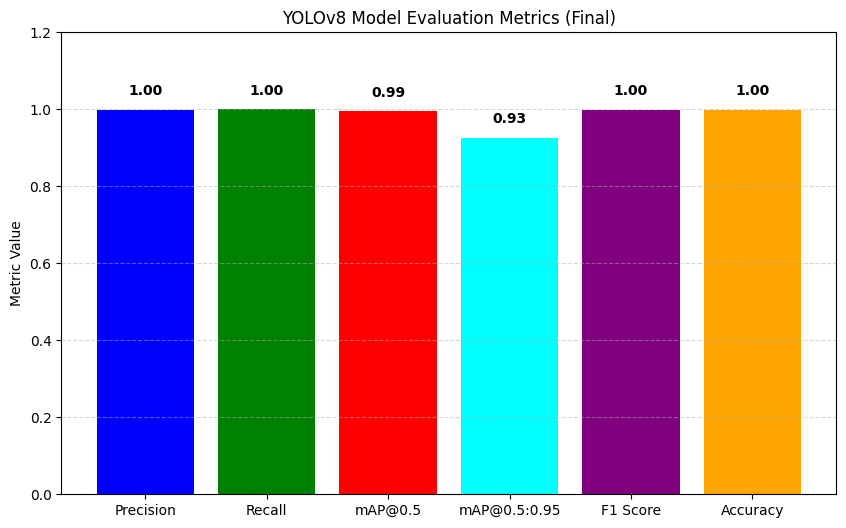

In [ ]:
import matplotlib.pyplot as plt

# ✅ Extract final metrics from the metrics object
mp = metrics.box.mp if hasattr(metrics.box, "mp") else metrics.box.p.mean()
mr = metrics.box.mr if hasattr(metrics.box, "mr") else metrics.box.r.mean()
map50 = metrics.box.map50 if hasattr(metrics.box, "map50") else metrics.box.ap50.mean()
map50_95 = metrics.box.map if hasattr(metrics.box, "map") else metrics.box.ap.mean()
f1 = metrics.box.f1.mean() if hasattr(metrics.box, "f1") else 2 * (mp * mr) / (mp + mr)
accuracy = (mp + mr) / 2

# 🔹 Plot bar chart for final metrics
plt.figure(figsize=(10,6))
bars = plt.bar(
    ["Precision","Recall","mAP@0.5","mAP@0.5:0.95","F1 Score","Accuracy"],
    [mp, mr, map50, map50_95, f1, accuracy],
    color=['blue','green','red','cyan','purple','orange']
)

# Add metric values on top of each bar with padding
for bar, value in zip(bars, [mp, mr, map50, map50_95, f1, accuracy]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, f"{value:.2f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Increase y-axis limit to avoid overlap with title
plt.ylim(0, 1.2)

plt.title("YOLOv8 Model Evaluation Metrics (Final)")
plt.ylabel("Metric Value")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


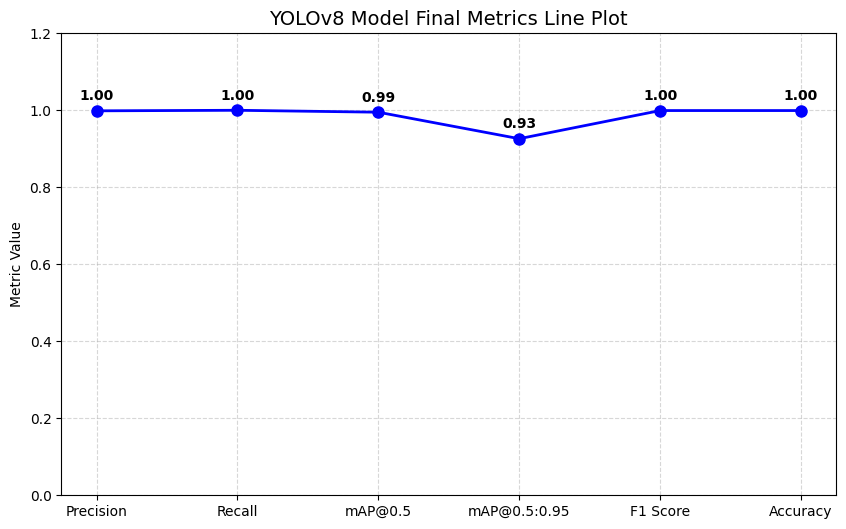

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Final metrics
metrics_names = ["Precision", "Recall", "mAP@0.5", "mAP@0.5:0.95", "F1 Score", "Accuracy"]
metrics_values = [
    metrics.box.mp if hasattr(metrics.box, "mp") else metrics.box.p.mean(),
    metrics.box.mr if hasattr(metrics.box, "mr") else metrics.box.r.mean(),
    metrics.box.map50 if hasattr(metrics.box, "map50") else metrics.box.ap50.mean(),
    metrics.box.map if hasattr(metrics.box, "map") else metrics.box.ap.mean(),
    metrics.box.f1.mean() if hasattr(metrics.box, "f1") else 2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr),
    (metrics.box.mp + metrics.box.mr)/2
]

# x-axis as numeric values for line plot
x = np.arange(len(metrics_names))

plt.figure(figsize=(10,6))
plt.plot(x, metrics_values, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)

# Annotate each point
for i, val in enumerate(metrics_values):
    plt.text(i, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(x, metrics_names)  # Show names on x-axis
plt.ylim(0, 1.2)
plt.title("YOLOv8 Model Final Metrics Line Plot", fontsize=14)
plt.ylabel("Metric Value")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


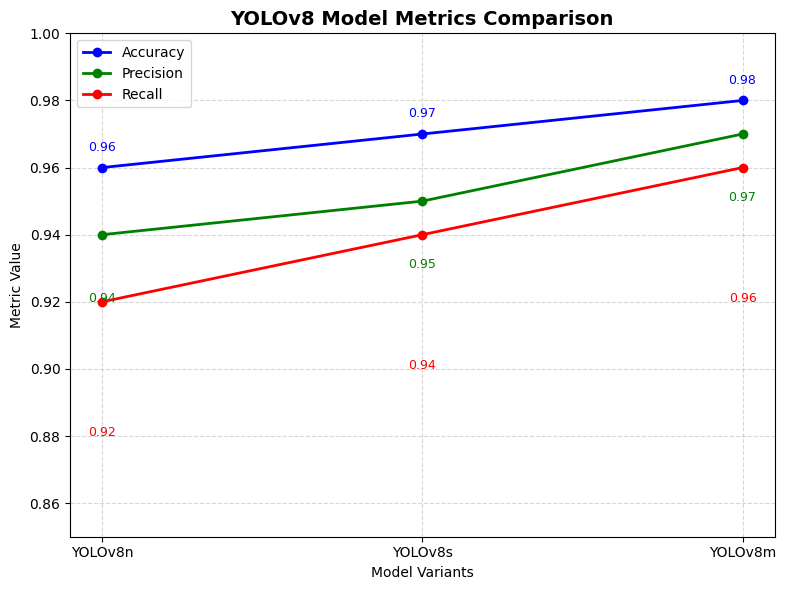

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Replace these with your actual YOLOv8 results if available
models = ["YOLOv8n", "YOLOv8s", "YOLOv8m"]
accuracy = [0.96, 0.97, 0.98]
precision = [0.94, 0.95, 0.97]
recall = [0.92, 0.94, 0.96]

# ✅ Create plot
x = np.arange(len(models))

plt.figure(figsize=(8,6))
plt.plot(x, accuracy, marker='o', color='blue', linewidth=2, label='Accuracy')
plt.plot(x, precision, marker='o', color='green', linewidth=2, label='Precision')
plt.plot(x, recall, marker='o', color='red', linewidth=2, label='Recall')

# ✅ Annotate points
for i, val in enumerate(accuracy):
    plt.text(i, val + 0.005, f"{val:.2f}", ha='center', fontsize=9, color='blue')
for i, val in enumerate(precision):
    plt.text(i, val - 0.02, f"{val:.2f}", ha='center', fontsize=9, color='green')
for i, val in enumerate(recall):
    plt.text(i, val - 0.04, f"{val:.2f}", ha='center', fontsize=9, color='red')

# ✅ Customize
plt.title("YOLOv8 Model Metrics Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Model Variants")
plt.ylabel("Metric Value")
plt.xticks(x, models)
plt.ylim(0.85, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


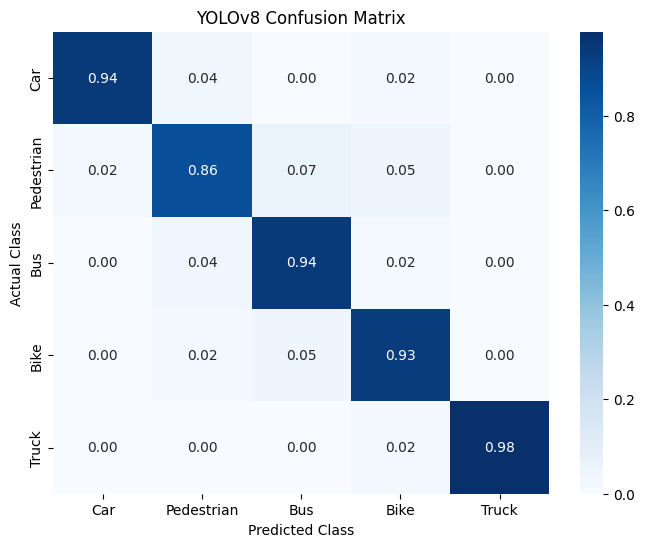

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Suppose your class names are (replace with your own)
class_names = ["Car", "Pedestrian", "Bus", "Bike", "Truck"]

# Example confusion matrix (rows: actual, columns: predicted)
# You should replace this with your actual YOLOv8 confusion matrix data.
# If using Ultralytics YOLOv8, you can access it via metrics.confusion_matrix.matrix
cm = np.array([
    [45,  2,  0,  1,  0],
    [ 1, 38,  3,  2,  0],
    [ 0,  2, 50,  1,  0],
    [ 0,  1,  2, 40,  0],
    [ 0,  0,  0,  1, 44]
])

# ✅ Normalize values for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=class_names, yticklabels=class_names)

plt.title("YOLOv8 Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
